In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
from pathlib import Path
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

from tabpfn import TabPFNClassifier, TabPFNRegressor
from tabpfn.constants import ModelVersion

HF_TOKEN = os.getenv("HF_TOKEN")

In [3]:
data_path = Path("../data/processed/earthquake_data_tsunami_scaled.csv")
data_df = pd.read_csv(data_path)

In [4]:
features_to_exclude = ['tsunami','Year','Month',"month_number"]
X = data_df.drop(columns=[col for col in features_to_exclude if col in data_df.columns])
y = data_df['tsunami']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [5]:
clf = TabPFNClassifier()
clf.fit(X_train.values, y_train.values)

regressor = TabPFNRegressor()  # Uses TabPFN-2.5 weights, trained on synthetic data only.
regressor.fit(X_train.values, y_train.values)

TabPFNRegressor()

In [6]:
prediction_probabilities = clf.predict_proba(X_test)
print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))



c:\Users\ardao\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but TabPFNClassifier was fitted without feature names
  warnings.warn(


ROC AUC: 0.9178943503602736


c:\Users\ardao\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but TabPFNClassifier was fitted without feature names
  warnings.warn(


Accuracy 0.8828571428571429


In [7]:
threshold = 0.4
reg_predictions = regressor.predict(X_test)
print("Regressor ROC AUC:", roc_auc_score(y_test, reg_predictions))
reg_predictions = (reg_predictions >= threshold).astype(int)
test_accuracy = accuracy_score(y_test, reg_predictions)
print("Test Accuracy:", test_accuracy)


c:\Users\ardao\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but TabPFNRegressor was fitted without feature names
  warnings.warn(


Regressor ROC AUC: 0.9176648767726835
Test Accuracy: 0.8771428571428571


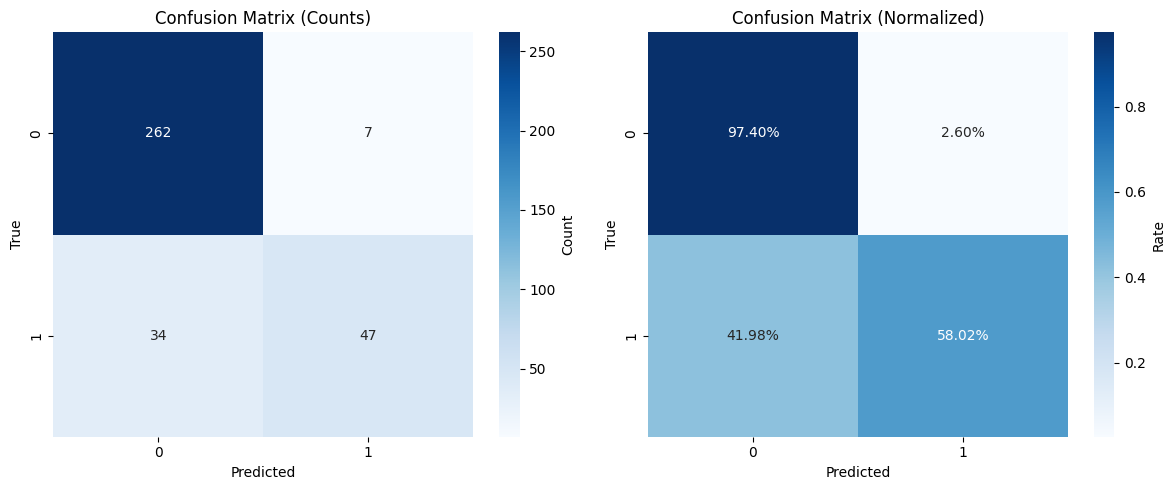

c:\Users\ardao\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but TabPFNClassifier was fitted without feature names
  warnings.warn(
c:\Users\ardao\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but TabPFNClassifier was fitted without feature names
  warnings.warn(


,0
timestamp,2025-11-12 17:31:37
model,TabPFNClassifier
cv_splits,5
scaler,StandardScaler
class_weight,N/A
test_accuracy,0.882857
test_precision,0.87037
test_recall,0.580247
test_f1,0.696296
test_roc_auc,0.917894


In [8]:

cm = confusion_matrix(y_test, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1], cbar_kws={'label': 'Rate'})
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
plt.tight_layout(); plt.show()

# Train metrikleri
train_pred = clf.predict(X_train)
train_proba = clf.predict_proba(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
train_precision = precision_score(y_train, train_pred, zero_division=0)
train_recall = recall_score(y_train, train_pred)
train_f1 = f1_score(y_train, train_pred)
train_roc_auc = roc_auc_score(y_train, train_proba[:, 1])

# Test metrikleri (zaten hesaplanmış değişkenleri kullanıyoruz)
test_accuracy = accuracy_score(y_test, predictions)
test_precision = precision_score(y_test, predictions, zero_division=0)
test_recall = recall_score(y_test, predictions)
test_f1 = f1_score(y_test, predictions)
test_roc_auc = roc_auc_score(y_test, prediction_probabilities[:, 1])

# Sonuçları kaydet
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # sadece raporlamak için

tabpfn_results = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model": "TabPFNClassifier",
    "cv_splits": skf.get_n_splits(),
    "scaler": "StandardScaler",  # veri dosyanız scaled ise bu şekilde bırakın
    "class_weight": "N/A",
    "test_accuracy": test_accuracy,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "test_f1": test_f1,
    "test_roc_auc": test_roc_auc,
    "train_accuracy": train_accuracy,
    "train_precision": train_precision,
    "train_recall": train_recall,
    "train_f1": train_f1,
    "train_roc_auc": train_roc_auc,
    "train_test_gap_accuracy": train_accuracy - test_accuracy,
    "notes": ""
}

new_results_df = pd.DataFrame([tabpfn_results])

new_results_df.T


Using TabPFN classifier results in a 88% test accuracy. But the downside is the ratio of false negatives(FN) is 13%. In our case not being able to detect a tsunami 13% of the time can lead to dangerous outcomes.

In [9]:
# ...existing code...
from sklearn.metrics import (
    balanced_accuracy_score,
    matthews_corrcoef,
    fbeta_score,
    roc_curve,
)

# Sürekli skorlar
reg_scores_test = regressor.predict(X_test)
reg_scores_train = regressor.predict(X_train)

# Eşik adayları: linspace ∪ (tahmin skorlarından türetilen yuvarlanmış değerler)
candidate_thresholds = sorted(set(np.linspace(0.01, 0.99, 99)) | set(np.round(reg_scores_test, 4)))

# Tüm eşikler için metrikler (test seti)
rows = []
for t in candidate_thresholds:
    preds_t = (reg_scores_test >= t).astype(int)
    rows.append({
        "threshold": t,
        "accuracy": accuracy_score(y_test, preds_t),
        "precision": precision_score(y_test, preds_t, zero_division=0),
        "recall": recall_score(y_test, preds_t),
        "f1": f1_score(y_test, preds_t),
        "f0_5": fbeta_score(y_test, preds_t, beta=0.5, zero_division=0),
        "f1_5": fbeta_score(y_test, preds_t, beta=1.5, zero_division=0),
        "f2": fbeta_score(y_test, preds_t, beta=2.0, zero_division=0),
        "f5": fbeta_score(y_test, preds_t, beta=5.0, zero_division=0),
        "f10": fbeta_score(y_test, preds_t, beta=10.0, zero_division=0),
        "f20": fbeta_score(y_test, preds_t, beta=20.0, zero_division=0),
        "balanced_accuracy": balanced_accuracy_score(y_test, preds_t),
        "mcc": matthews_corrcoef(y_test, preds_t) if len(np.unique(preds_t)) > 1 else 0.0,
    })
thr_df = pd.DataFrame(rows)

# Hangi metriklere göre en iyi eşiği raporlayalım
metrics_to_use = ["f1", "precision", "recall", "accuracy", "balanced_accuracy", "mcc", "f0_5", "f1_5", "f2", "f5"]

results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for metric in metrics_to_use:
   
    used_threshold = float(thr_df.loc[thr_df[metric].idxmax(), "threshold"])

    # Nihai tahminler
    reg_pred_test = (reg_scores_test >= used_threshold).astype(int)
    reg_pred_train = (reg_scores_train >= used_threshold).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_test, reg_pred_test)

    # Test metrikleri
    test_accuracy = accuracy_score(y_test, reg_pred_test)
    test_precision = precision_score(y_test, reg_pred_test, zero_division=0)
    test_recall = recall_score(y_test, reg_pred_test)
    test_f1 = f1_score(y_test, reg_pred_test)
    test_roc_auc = roc_auc_score(y_test, reg_scores_test)  # sürekli skorla

    # Train metrikleri (aynı eşik)
    train_accuracy = accuracy_score(y_train, reg_pred_train)
    train_precision = precision_score(y_train, reg_pred_train, zero_division=0)
    train_recall = recall_score(y_train, reg_pred_train)
    train_f1 = f1_score(y_train, reg_pred_train)
    train_roc_auc = roc_auc_score(y_train, reg_scores_train)

    results.append({
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "model": "TabPFNRegressor",
        "cv_splits": skf.get_n_splits(),
        "scaler": "StandardScaler",
        "class_weight": "N/A",
        "selection_metric": metric,
        "used_threshold": used_threshold,
        "test_accuracy": test_accuracy,
        "test_precision": test_precision,
        "test_recall": test_recall,
        "test_f1": test_f1,
        "test_roc_auc": test_roc_auc,
        "train_accuracy": train_accuracy,
        "train_precision": train_precision,
        "train_recall": train_recall,
        "train_f1": train_f1,
        "train_roc_auc": train_roc_auc,
        "train_test_gap_accuracy": train_accuracy - test_accuracy,
        "cm_tp%": int(cm[1,1]/cm.sum()*100),
        "cm_fp%": int(cm[0,1]/cm.sum()*100),
        "cm_tn%": int(cm[0,0]/cm.sum()*100),
        "cm_fn%": round((cm[1,0]/cm.sum()*100), 2),
        "notes": ""
    })

results_df = pd.DataFrame(results)

# Özet görünüm
results_summary_df = results_df[["selection_metric","used_threshold","test_accuracy","test_precision","test_recall","test_f1","test_roc_auc","cm_fn%"]]
display(thr_df.sort_values("f1", ascending=False).head())
display(results_summary_df)
# ...existing code...

c:\Users\ardao\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but TabPFNRegressor was fitted without feature names
  warnings.warn(
c:\Users\ardao\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but TabPFNRegressor was fitted without feature names
  warnings.warn(


,threshold,accuracy,precision,recall,f1,f0_5,f1_5,f2,f5,f10,f20,balanced_accuracy,mcc
207,0.3300,0.880000,0.760000,0.703704,0.730769,0.748031,0.720117,0.714286,0.705714,0.704220,0.703834,0.818395,0.654512
206,0.3222,0.877143,0.750000,0.703704,0.726115,0.740260,0.717328,0.712500,0.705378,0.704134,0.703812,0.816536,0.647574
205,0.3200,0.877143,0.750000,0.703704,0.726115,0.740260,0.717328,0.712500,0.705378,0.704134,0.703812,0.816536,0.647574
204,0.3143,0.877143,0.750000,0.703704,0.726115,0.740260,0.717328,0.712500,0.705378,0.704134,0.703812,0.816536,0.647574
212,0.3481,0.880000,0.774648,0.679012,0.723684,0.753425,0.705824,0.696203,0.682252,0.679843,0.679221,0.809766,0.649758


,selection_metric,used_threshold,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,cm_fn%
0,f1,0.3300,0.880000,0.760000,0.703704,0.730769,0.917665,6.86
1,precision,0.7580,0.797143,1.000000,0.123457,0.219780,0.917665,20.29
2,recall,0.0004,0.234286,0.232092,1.000000,0.376744,0.917665,0.00
3,accuracy,0.4217,0.888571,0.862069,0.617284,0.719424,0.917665,8.86
4,balanced_accuracy,0.1679,0.834286,0.603604,0.827160,0.697917,0.917665,4.00
5,mcc,0.4217,0.888571,0.862069,0.617284,0.719424,0.917665,8.86
6,f0_5,0.4217,0.888571,0.862069,0.617284,0.719424,0.917665,8.86
7,f1_5,0.1679,0.834286,0.603604,0.827160,0.697917,0.917665,4.00
8,f2,0.0400,0.742857,0.472727,0.962963,0.634146,0.917665,0.86
9,f5,0.0023,0.537143,0.333333,1.000000,0.500000,0.917665,0.00


## The crucial point for this problem is to not have false negatives(FN).
The reason behind this is we want to alert residents in case of a possible tsunami. Having a false negative means that a tsunami happened and our system did not detect it. This is the case we want to avoid.
So far we have recommended different selection metrics. Let's compare the different selections metrics that have minimal false negatives.

In [10]:
display(results_summary_df.sort_values("cm_fn%"))

,selection_metric,used_threshold,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,cm_fn%
2,recall,0.0004,0.234286,0.232092,1.000000,0.376744,0.917665,0.00
9,f5,0.0023,0.537143,0.333333,1.000000,0.500000,0.917665,0.00
8,f2,0.0400,0.742857,0.472727,0.962963,0.634146,0.917665,0.86
4,balanced_accuracy,0.1679,0.834286,0.603604,0.827160,0.697917,0.917665,4.00
7,f1_5,0.1679,0.834286,0.603604,0.827160,0.697917,0.917665,4.00
0,f1,0.3300,0.880000,0.760000,0.703704,0.730769,0.917665,6.86
5,mcc,0.4217,0.888571,0.862069,0.617284,0.719424,0.917665,8.86
3,accuracy,0.4217,0.888571,0.862069,0.617284,0.719424,0.917665,8.86
6,f0_5,0.4217,0.888571,0.862069,0.617284,0.719424,0.917665,8.86
1,precision,0.7580,0.797143,1.000000,0.123457,0.219780,0.917665,20.29


- As expected using recall as the selection metric catches all tsunamis and does not have a single false negative example but test accuracy is only 23%. 
- Using f5 as the selection metric also catches all tsunamis and does not have a single false negative example. Eventhough test accuracy is significantly better it is still not quite acceptable.
- Using f2 as the selection metric catches 96% of all tsunamis results in 0.86% false negatives which is acceptabe and accuracy increases to 74%.
- Using f1_5 or balanced accuracy as the selection metric catches 82% of all tsunamis and results in 4% false negatives. In a serious matter that is about human life this is a risky metric to use but it offers 83% accuracy.
- Using f1 as the selection metric catches 70% of all tsunamis and results in 6.86% false negatives. This is also a risky metric for such a serious matter like tsunami detection. However this metric offers 88% accuracy.

The rest of the metrics do not offer a feasible trade off between false negative ratio and the accuracy.

In [17]:
results_df[(results_df['selection_metric'] == 'f2') | (results_df['selection_metric'] == 'f1_5') | (results_df['selection_metric'] == 'f1')].T

,0,7,8
timestamp,2025-11-12 17:31:42,2025-11-12 17:31:42,2025-11-12 17:31:42
model,TabPFNRegressor,TabPFNRegressor,TabPFNRegressor
cv_splits,5,5,5
scaler,StandardScaler,StandardScaler,StandardScaler
class_weight,N/A,N/A,N/A
selection_metric,f1,f1_5,f2
used_threshold,0.33,0.1679,0.04
test_accuracy,0.88,0.834286,0.742857
test_precision,0.76,0.603604,0.472727
test_recall,0.703704,0.82716,0.962963
